In [1]:
import torch 
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import ImitationLearningDataset
from model import Network
from config import get_cfg_defaults

/home/johann/dev/conditional-imitation-learning-pytorch/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = get_cfg_defaults() 
print(cfg)

DATA:
  IMG_HEIGHT: 88
  IMG_WIDTH: 200
  ROOT: /data/AgentHuman
  TRAIN_DIR: /data/AgentHuman/SeqTrain
  TRAIN_IMGS_DIR: /data/AgentHuman/SeqTrain/images
  TRAIN_TARGETS_DIR: /data/AgentHuman/SeqTrain/targets
  VAL_DIR: /data/AgentHuman/SeqVal
  VAL_IMGS_DIR: /data/AgentHuman/SeqVal/images
  VAL_TARGETS_DIR: /data/AgentHuman/SeqVal/targets
MODEL:
  NUM_ACTIONS: 3
  NUM_COMMANDS: 4
SYSTEM:
  NUM_GPUS: 1
  NUM_WORKERS: 4
TRAIN:
  BATCH_SIZE: 384
  DROPOUT: 0.5
  LR: 0.0002
  NUM_EPOCHS: 20
  OPTIM: adam
  PRINT_INTERVAL: 500
VAL:
  BATCH_SIZE: 8
  PRINT_INTERVAL: 1000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
train_dataset = ImitationLearningDataset(cfg, "train")
print(train_dataset)

In [5]:
len(train_dataset.imgs)

657600

In [6]:
for org_img, img, speed, command, target in train_dataset: 
    print(f"org image: {org_img.shape}") 
    print(f"speed: {speed}") 
    print(f"command: {command}")
    print(f"target: {target}") 
    break

org image: (88, 200, 3)
speed: tensor([16.1350])
command: tensor([1., 0., 0., 0.])
target: tensor([-0.0398,  0.5000,  0.0000])


In [11]:
import matplotlib.pyplot as plt 
import cv2 

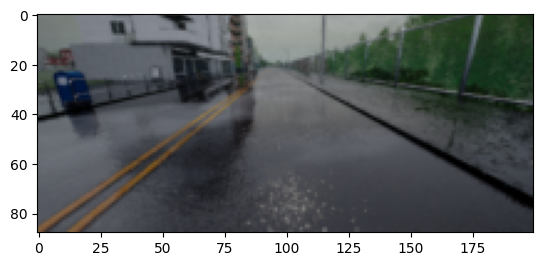

In [12]:
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
plt.imshow(org_img)


In [14]:
model = Network(cfg)
model = model.to(device)

In [21]:
img = img.to(device).unsqueeze(0)
print(f"img shape: {img.shape}")
speed = speed.to(device).unsqueeze(0)
command = command.to(device).unsqueeze(0)
target = target.to(device).unsqueeze(0)


img shape: torch.Size([1, 3, 88, 200])


In [22]:
model.eval()
with torch.no_grad():
    out = model(img, speed, command)

In [23]:
out.shape

torch.Size([1, 3])

In [24]:
print(out)

tensor([[0.0359, 0.0242, 0.2173]], device='cuda:0')


In [25]:
print(target)

tensor([[-0.0398,  0.5000,  0.0000]], device='cuda:0')


In [26]:
loss_fn = torch.nn.MSELoss()

In [27]:
steer_loss = loss_fn(out[:, 0], target[:, 0])
print(steer_loss)

tensor(0.0057, device='cuda:0')


In [28]:
acc_loss = loss_fn(out[:, 1:], target[:, 1:])
print(acc_loss)

tensor(0.1368, device='cuda:0')


In [35]:
c = 0 
print("speed <> brake")
for org_img, img, speed, command, target in train_dataset: 
    if target[2] != 0.0: 
        c += 1  
        # print(f"{speed.item()} <> {target[2]}")

print(f"number of non zero brake values: {c}") 

speed <> brake
number of non zero brake values: 116101


In [36]:
len(train_dataset.targets)

657600

In [37]:
c = 0 
for org_img, img, speed, command, target in train_dataset: 
    if speed < 0.0: 
        c += 1  
        # print(f"{speed.item()} <> {target[2]}")

print(f"number of negative speed values: {c}") 

number of negative speed values: 76336
